# Demonstration of QAD variants in 2D parameter space

This notebook takes about a minute on a laptop computer as is.
Should this be too long, you may consider to reduce `num_points` in the last cell,
which determines the resolution of the landscapes in the plots and influences the
runtime quadratically.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import lib
import matplotlib as mpl

In [2]:
# Set up a qubit device with 2 qubits.
dev = qml.device('default.qubit', wires=2)

# Initialize two parameters. This will correspond to the position
# in the two-dimensional parameter space around which we attempt/perform
# the reconstruction with the various QAD variants.
par = np.array([0.33, 0.43])

In [3]:
# Set up the first circuit, the cost function of which is displayed in the first row in Figure 4.
# This circuit depends on two parameters that feed into one gate with a single frequency each.
@qml.qnode(dev)
def circuit_1(param):
    qml.RX(param[0], wires=[0])
    qml.CNOT(wires=[0,1])
    qml.RY(param[1], wires=[1])
    return qml.expval(qml.PauliY(0)@qml.PauliZ(1))

# Build the original QAD model that coincides with the landscape only locally.
QAD_1 = lib.build_qad_model(circuit_1, par)

# Build the extended QAD model that coincides with the landscape globally, because the 
# parameter space is only two dimensional.
extQAD_1 = lib.build_extended_qad_model(circuit_1, par)

# Build the generalized QAD model. It coincides with the extended model for gates
# with a single frequency like in circuit_1, and thus with the original cost function.
genQAD_1 = lib.trig_interpolation_qad(circuit_1, par, R=[1, 1], extended=True)

In [4]:
# Set up the second circuit, the cost function of which is displayed in the second row in Figure 4.
# This circuit depends on two parameters that feed into multiple gates with a single frequency each,
# leading to a dependency of the cost function with two frequencies per parameter.
@qml.qnode(dev)
def circuit_2(param):
    qml.RX(param[0], wires=[0])
    qml.RX(param[0], wires=[1])
    qml.CNOT(wires=[0,1])
    qml.RY(param[1], wires=[0])
    qml.RY(param[1], wires=[1])
    return qml.expval(qml.PauliZ(0)@qml.PauliX(1))

# Build the original QAD model that coincides with the landscape only locally.
# Due to the higher frequency contributions, it deviates from the original
# cost function more quickly than for `circuit_1`.
QAD_2 = lib.build_qad_model(circuit_2, par)

# Build the extended QAD model. It does no longer coincide with the original cost
# function globally, because the latter contains higher frequency contributions
# that are not taken into account by this model. This model may not even reproduce
# the local landscape well.
extQAD_2 = lib.build_extended_qad_model(circuit_2, par)

# Build the generalized QAD model. It no longer coincides with the extended model
# but instead is able to reproduce the full cost landscape for two parameters.
genQAD_2 = lib.trig_interpolation_qad(circuit_2, par, R=[2, 2], extended=True)

In [5]:
# Some plot options to make the plot pretty
alpha = 0.6
green = "#209494"
orange = "#ED7D31"
red = "xkcd:brick red"
blue = "xkcd:ocean blue"
bg_alpha = 0.1
bg_red = mpl.colors.to_rgb(red)+(bg_alpha,)
bg_green = mpl.colors.to_rgb(green)+(bg_alpha,)
colors = [green, red, orange, blue]
layout_kwargs = {"pad": 2, "w_pad": 2.5}

def plot_cost_and_model(funs, models, params, equal_signs, shift_radius=5 * np.pi / 8, num_points=20):
    """Plot original cost functions and model functions
    
    Args:
        funs (list[callable]): Original function per row, plotted on the left-most subplots.
        models (list[callable]): Model functions per row, plotted from left to right.
        params (array): (2D-)Parameters at which to plot the functions and models.
        equal_signs (list[list[str]]): Latex strings of equal/unequal signs to insert between subplots.
        shift_radius (float): maximal distance per parameter that determines the plot range.
            (Radius in the \ell_\infinity-norm sense)
        num_points (int): Number of points to evaluate the function on, per parameter direction.
            The total number of evaluations per function/model will be num_points ** 2.
        ticks (bool): Whether to draw ticks on the plots or not.
    """

    coords = np.linspace(-shift_radius, shift_radius, num_points)
    X, Y = np.meshgrid(coords + params[0], coords + params[1])
    
    num_funs = len(funs)
    num_models = len(models[0])
    # Compute the original cost function and the model on the grid.
    Z_original = np.zeros((num_funs, num_points, num_points))
    Z_model = np.zeros((num_funs, num_models, num_points, num_points))
    for j, (fun, models_) in enumerate(zip(funs, models)):
        Z_original[j] = np.array([[fun(params + np.array([t1, t2])) for t2 in coords] for t1 in coords])
        for i, model in enumerate(models_):
            Z_model[j, i] = np.array([[model(np.array([t1, t2])) for t2 in coords] for t1 in coords])

    # Set up subplots.
    figsize = (4*(num_models+1), 4*num_funs)
    fig, axs = plt.subplots(num_funs, num_models+1, subplot_kw={"projection": "3d"}, figsize=figsize)
    
    # Iterate over rows
    for j, row in enumerate(axs):
        # Plot original function values
        row[-1].plot_surface(X, Y, Z_original[j], color=colors[-1], alpha=alpha)
        
        # Iterate over model columns
        for i, ax in enumerate(row[:-1]):
            # Plot models
            ax.plot_surface(X, Y, Z_model[j, i], color=colors[i], alpha=alpha)
            fig.text(0.25 * (i + 1), 0.75 - 0.5 * j, equal_signs[j, i], fontsize=25, ha='center')

    plt.tight_layout(**layout_kwargs)
    return axs

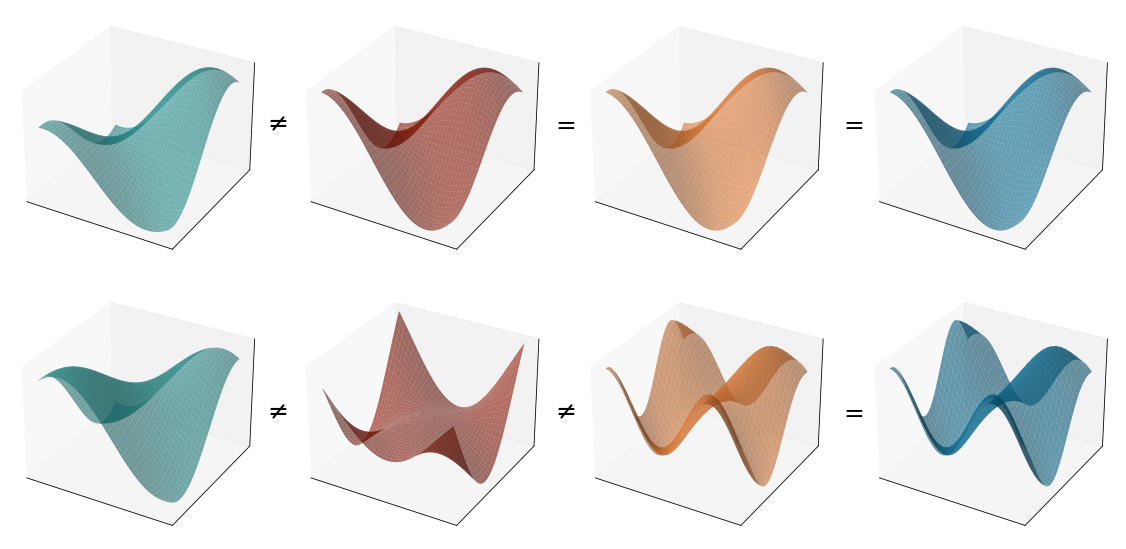

In [6]:
# Resolution for the plot, quadratically determines runtime of this cell. Suggestion: 60 (35 secs on Laptop)
num_points = 60
# Equality and un-equality signs for the plot, per row.
equal_signs = np.array([['$\\neq$', '$=$', '$=$'],['$\\neq$', '$\\neq$', '$=$']])

# Original cost functions per row
funs = [circuit_1, circuit_2]

# Model functions per row
models = [[QAD_1, extQAD_1, genQAD_1],[QAD_2, extQAD_2, genQAD_2]]

# Plot the cost function as well as the models, for both rows.
axs = plot_cost_and_model(funs, models, par, equal_signs, num_points=num_points)
plt.savefig(f"QAD_landscapes_ticks.pdf")
[[ax.set(xticks=[], yticks=[], zticks=[]) for ax in row] for row in axs]
plt.savefig(f"QAD_landscapes_noticks.pdf")